## Imports

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import os
from scipy.interpolate import interp1d

from celluloid import Camera

In [2]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
ROOT_PATH = '/Users/nastya/dev/time_series_prediction/'
sns.set_style('whitegrid')

## Plot functions

Healing animation and statistics

In [6]:
def plot_stats(h, stats_ds=None, stats_filename=None, savefig_path=None, \
    flip_plot=False, color='blue', fig=None, axs=None, legend_title='', pointplot=False):
    '''Plot statistics from .csv file or from statictics DataFrame

    Parameters
    ----------
    stats_ds: pd.DataFrame
        columns: points_left, n_iterations, non_predictable, rmse, mape
    stats_filename: str
        Path to stats.csv file: pd.DataFrame with columns 
        points_left, n_iterations, non_predictable, rmse, mape
    savefig_path: str
        Path to save plot, None if saving is not needed
    '''
    if stats_ds is None and stats_filename is None:
        return 
    if stats_ds is None:
        stats_ds = pd.read_csv(stats_filename, index_col=0)
    if fig is None:
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

    xlabel = 'points left' if not flip_plot else 'points thrown'
    x = stats_ds['points_left'].values
    if flip_plot:
        x = h - x

    xticks = get_xticks(h)
    if pointplot:
        p1 = sns.pointplot(x=x, y=stats_ds['n_iterations'], ax=axs[0][0], color=color, label=legend_title, scale=0.5)
        axs[0][0].set(xlabel=xlabel, ylabel='iterations', \
            title='Number of iterations to converge', xticks=xticks)
        p1.axes.grid(True, axis='both')

        p2 = sns.pointplot(x=x, y=stats_ds['non_predictable'], ax=axs[0][1], color=color, label=legend_title, scale=0.5)
        axs[0][1].set(xlabel=xlabel, ylabel='non-predictable points', \
            title='Number of non-predicable points', xticks=xticks)
        p2.axes.grid(True, axis='both')

        p3 = sns.pointplot(x=x, y=stats_ds['rmse'], ax=axs[1][0], color=color, label=legend_title, scale=0.5)
        axs[1][0].set(xlabel=xlabel, ylabel='RMSE', title='RMSE', xticks=xticks)
        axs[1][0].legend()
        p3.axes.grid(True, axis='both')

        p4 = sns.pointplot(x=x, y=stats_ds['mape'], ax=axs[1][1], color=color, label=legend_title, scale=0.5)
        axs[1][1].set(xlabel=xlabel, ylabel='MAPE', title='MAPE', xticks=xticks)
        p4.axes.grid(True, axis='both')
    else:
        sns.lineplot(x=x, y=stats_ds['n_iterations'], ax=axs[0][0], color=color, label=legend_title)
        axs[0][0].set(xlabel=xlabel, ylabel='iterations', \
            title='Number of iterations to converge', xticks=xticks)

        sns.lineplot(x=x, y=stats_ds['non_predictable'], ax=axs[0][1], color=color, label=legend_title)
        axs[0][1].set(xlabel=xlabel, ylabel='non-predictable points', \
            title='Number of non-predicable points', xticks=xticks)

        sns.lineplot(x=x, y=stats_ds['rmse'], ax=axs[1][0], color=color, label=legend_title)
        axs[1][0].set(xlabel=xlabel, ylabel='RMSE', title='RMSE', xticks=xticks)

        sns.lineplot(x=x, y=stats_ds['mape'], ax=axs[1][1], color=color, label=legend_title)
        axs[1][1].set(xlabel=xlabel, ylabel='MAPE', title='MAPE', xticks=xticks)

    if savefig_path is not None:
        fig.savefig(savefig_path)

    # plt.show()

    return fig, axs


def plot_unified_and_possible_preds(up, pp, Y2, ax=None, \
    title='Unified and possible predictions', savefig_path=None):
    '''Plot unified predictions and corresponding possible predictions with true values
    for self-healing algorithm

    Parameters
    ----------
    up: list or 1D np.ndarray
        List of unified predictions
    pp: list of lists or list of np.ndarrays
        List of lists of possible predictions
    Y2: list or 1D np.ndarray
        True values of predicted points
    ax: plt.Axis
        Axis to plot on, for animation to work
    title: str
        Plot title
    '''
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 14))
    h = len(up)
    x = list(range(1, h + 1))
    predictable = np.argwhere(up != 'N').reshape(1, -1)[0]
    x = np.take(x, predictable)
    y = np.take(up, predictable)
    y = y.astype(float)
    non_pred = np.argwhere(up == 'N').reshape(1, -1)[0] + 1
    print(non_pred)

    # pp = np.delete(pp, axis=0)
    x2 = []
    y2 = []
    for i in range(len(pp)):
        x2.extend([i + 1] * len(pp[i]))
        y2.extend(pp[i])

    sns.scatterplot(x=x2, y=y2, color='green', ax=ax, linewidth=0, alpha=0.5, s=20)
    sns.scatterplot(x=x, y=y, color='red', ax=ax, linewidth=0, s=100)
    sns.lineplot(x=x, y=y, color='red', ax=ax, alpha=0.5)
    sns.lineplot(x=list(range(1, h+1)), y=Y2[:h], ax=ax, color='blue')
    sns.scatterplot(x=non_pred, y=[0] * len(non_pred), ax=ax, color='purple')

    ax.set(title=title, ylabel='value', xlabel='h')

    if savefig_path is not None:
        fig.savefig(savefig_path)

    plt.show()


def plot_healing_animation(working_path, Y2, title='Self-healing animation', \
    saveanim_path=None, savefig_path=None, up_logs=None, pp_logs=None, true_points=[]):
    '''Function for animated plot for self-healing
    each new frame is self-healing iteration
    In working folder must be presented files:
        unified_pred_logs.dat
        possible_pred_logs.dat
    '''

    if up_logs == None and pp_logs == None:
        with open(working_path + 'unified_pred_logs.dat', 'rb') as f:
            up_logs = pickle.load(f)

        with open(working_path + 'possible_pred_logs.dat', 'rb') as f:
            pp_logs = pickle.load(f)

    fig, ax = plt.subplots(figsize=(16, 10))
    n_frames = len(up_logs)
    h = len(up_logs[0])
    if len(true_points) > 0:
        true_x = np.argwhere(true_points != 'N').reshape(1, -1)[0]
    else:
        true_x = []

    camera = Camera(fig)
    ticks = list(range(0, h, 5))
    for i in range(n_frames):
        if len(true_points) > 0:
            sns.scatterplot(x=true_x + 1, y=np.take(true_points, true_x).astype(float), color='blue', s=50, ax=ax)
        plot_unified_and_possible_preds(up_logs[i], pp_logs[i], Y2, ax=ax, title=title)
        ax.set(xlabel='h', ylabel='value', xticks=ticks, title=title)
        camera.snap()

    anim = camera.animate(blit=True, interval=2000, repeat=True, repeat_delay=2000)
    if saveanim_path is not None:
        anim.save(saveanim_path)
    if savefig_path is not None:
        fig.savefig(savefig_path)


def get_xticks(h):
    if h <= 20:
        xticks = list(range(0, h + 1, 2))
    elif h <= 50:
        xticks = list(range(0, h + 1, 5))
    else:
        xticks = list(range(0, h + 1, 10))
    return xticks

Main experiment errors, get prediction matrix and plot errors

In [7]:
def plot_errors(rmses, mapes, non_preds, exp_names=[], fig_title=''):
    '''Plot function for errors

    Parameters
    ----------
    rmses: list of lists
        List of RMSE lists for each experiment in comparison
    mapes: list of lists
        List of MAPE -//-
    non_preds: list of lists
        List of percentage of non-predictable points -//-
    '''
    # fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(9, 18))
    axd = plt.figure(constrained_layout=True, figsize=(18, 12)).subplot_mosaic(
        """
        AABB
        .CC.
        """
    )
    ax0 = axd['A']
    ax1 = axd['B']
    ax2 = axd['C']
    n_experiments = len(rmses)
    h = len(rmses[0])
    x = list(range(1, h + 1))
    colors = sns.color_palette('deep', 10)
    if len(exp_names) == 0:
        exp_names = [''] * n_experiments
    for i in range(n_experiments):
        sns.lineplot(x=x, y=rmses[i], color=colors[i], ax=ax0, label=exp_names[i])
        sns.lineplot(x=x, y=mapes[i], color=colors[i], ax=ax1, label=exp_names[i])
        sns.lineplot(x=x, y=non_preds[i], color=colors[i], ax=ax2, label=exp_names[i])
    
    ax0.set(xlabel='prediction horizon (h)', ylabel='RMSE', title='RMSE')
    ax1.set(xlabel='prediction horizon (h)', ylabel='MAPE', title='MAPE')
    ax2.set(xlabel='prediction horizon (h)', ylabel='Percentage of non-predictable', title='Percentage of non-predictable points')
    
    plt.show()

    return axd


def get_prediction_matrix_from_file(filepath, h_max, n_iterations):
    # format
    # h - test_i - unified_prediction - possible_predictions
    prediction_matrix = np.empty((h_max, n_iterations), dtype=object)
    with open(filepath, 'rb') as f:
        while True:
            try:
                (h, test_i) = pickle.load(f)
                unified_prediction = pickle.load(f)
                # possible_prediction = pickle.load(f)

                prediction_matrix[h - 1][test_i] = unified_prediction
            except EOFError:
                break
    return prediction_matrix


def get_errors_from_prediction_matrix(prediction_matrix, h_max, n_iterations):
    # h_max = prediction_matrix.shape[0]
    # n_iterations = prediction_matrix.shape[1]
    n_test_passed = 31 + h_max

    Y_true = Y2[n_test_passed:n_test_passed+n_iterations]
    # print(len(Y_true), n_test_passed+n_iterations)

    rmse = []
    mape = []
    npr = []
    for h in range(h_max):
        unified_preds = prediction_matrix[h][:n_iterations]
        predictable = np.argwhere(unified_preds != 'N')
        unified_preds_predicted = np.take(unified_preds, predictable).astype(float)
        if len(np.take(Y_true, predictable)) > 0:
            rmse.append(np.sqrt(mean_squared_error(np.take(Y_true, predictable), \
                unified_preds_predicted)))
            mape.append(mean_absolute_percentage_error(np.take(Y_true, predictable), \
                unified_preds_predicted))
        else:
            rmse.append(np.nan)
            mape.append(np.nan)
        npr.append(np.count_nonzero(unified_preds == 'N') / n_iterations)
    return rmse, mape, npr


def plot_experiment_results(working_directory, exp_short_names, \
    h_max, n_iterations, exp_names=None, fig_title=''):

    rmses = []
    mapes = []
    non_preds = []
    if exp_names is None:
        exp_names = exp_short_names
    for exp_short_name in exp_short_names:
        # prediction_matrix = get_prediction_matrix_from_file(\
        #     os.path.join(working_directory, 'predictions_' + exp_short_name + '.dat'),\
        #     h_max, n_iterations)
        with open(os.path.join(working_directory, 'pm_' + exp_short_name + '.dat'), 'rb') as f:
            prediction_matrix = pickle.load(f)
            prediction_matrix = np.delete(prediction_matrix, (0), axis=0)
        rmse, mape, npr = get_errors_from_prediction_matrix(prediction_matrix, h_max, n_iterations)
        rmses.append(rmse)
        mapes.append(mape)
        non_preds.append(npr)
    
    fig = plot_errors(rmses, mapes, non_preds, exp_names, fig_title)
    return fig


Thrown points experiment results and healing errors progression

In [8]:
def plot_thrown_points_exp_results(working_directory, exp_short_names, \
    h_max, exp_names, fig_title, pointplot=False):
    colors = sns.color_palette('tab10', 10)
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 14))
    fig.suptitle(fig_title)
    for i in range(len(exp_short_names)):
        stats_ds = pd.DataFrame(columns=['points_left', 'n_iterations', \
            'non_predictable', 'rmse', 'mape'])
        with open(os.path.join(working_directory, \
            'predictions_' + exp_short_names[i] + '.dat'), 'rb') as f:
            while True:
                try:
                    thrown = pickle.load(f)
                    unified_preds = pickle.load(f)
                    n_iterations = pickle.load(f)
                    predictable = np.argwhere(unified_preds != 'N').reshape(1, -1)[0]
                    # print(len(predictable), unified_preds)
                    # print(thrown, unified_preds, n_iterations)
                    if len(predictable) > 0:
                        stats_ds = stats_ds.append({
                            'points_left' : h_max - thrown, 
                            'n_iterations' : n_iterations, 
                            'non_predictable' : h_max - len(predictable), 
                            'rmse' : np.sqrt(mean_squared_error(np.take(Y2[:h_max], predictable), np.take(unified_preds, predictable))), 
                            'mape' : mean_absolute_percentage_error(np.take(Y2[:h_max], predictable), np.take(unified_preds, predictable))
                        }, ignore_index=True)
                    else:
                        stats_ds = stats_ds.append({
                            'points_left' : h_max - thrown, 
                            'n_iterations' : n_iterations, 
                            'non_predictable' : h_max - len(predictable), 
                            'rmse' : np.nan, 
                            'mape' : np.nan
                        }, ignore_index=True)
                except EOFError:
                    break

        fig, axs = plot_stats(h_max, stats_ds=stats_ds, \
            flip_plot=True, color=colors[i], fig=fig, axs=axs, \
                legend_title=exp_names[i], pointplot=pointplot) 
    return fig


def plot_healing_errors_progression(Y2, up_logs):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(27, 6))
    n_iterations = len(up_logs)
    h = len(up_logs[0])
    rmses = []
    mapes = []
    non_preds = []
    for i in range(n_iterations):
        predictable = np.argwhere(up_logs[i] != 'N').reshape(1, -1)[0]
        rmses.append(np.sqrt(mean_squared_error(np.take(up_logs[i], predictable), \
            np.take(Y2[:h], predictable))))
        mapes.append(mean_absolute_percentage_error(np.take(up_logs[i], predictable), \
            np.take(Y2[:h], predictable)))
        non_preds.append(h - len(predictable))

    sns.lineplot(x=list(range(1, n_iterations + 1)), y=rmses, ax=axs[0])
    sns.lineplot(x=list(range(1, n_iterations + 1)), y=mapes, ax=axs[1])
    sns.lineplot(x=list(range(1, n_iterations + 1)), y=non_preds, ax=axs[2])
    axs[0].set(xlabel='prediction horizon (h)', ylabel='RMSE', title='RMSE')
    axs[1].set(xlabel='prediction horizon (h)', ylabel='MAPE', title='MAPE')
    axs[2].set(xlabel='prediction horizon (h)', ylabel='Percentage of non-predictable', title='Percentage of non-predictable points')

    return fig
    

def plot_pp_logs_spreads(pp_logs):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 8))
    color_palette = sns.color_palette('hls', 10)
    sns.scatterplot(x=[0] * len(pp_logs[1][25]), y=pp_logs[1][25], color=color_palette[0], ax=ax)
    for i in range(1, len(pp_logs[1:]) - 1):
        y = pp_logs[i + 1][25]
        y = y[len(pp_logs[i][25]):]
        # print(len(pp_logs[i+1][25]), len(pp_logs[i][25]))
        sns.scatterplot(x=[i] * len(y), y=y, color=color_palette[i], ax=ax)

    return fig

Plot patterns based on healing logs
E.g. in [initial_algorithm](results/predictions/04.08-14/patterns_question/initial_algorithm)

In [9]:
def plot_patterns(iteration, logs_23, label_mapping):
    h = 100
    n_clusters = len(np.unique(list(label_mapping[23 + 100 * iteration].values())))
    fig, ax = plt.subplots(nrows=n_clusters, ncols=1, figsize=(16, 12 * n_clusters))

    for i in range(len(logs_23[iteration])):
        cluster = label_mapping[23 + 100 * iteration].get(logs_23[iteration][i][0], -1)
        pattern = logs_23[iteration][i][2]
        j = logs_23[iteration][i][1]
        x = [24] * 4
        for k in range(j):
            x[k] -= np.sum(pattern[k:j])
        for k in range(j+1,4):
            x[k] += np.sum(pattern[j:k])

        y = [up_logs[iteration + 1][x[k] - 1] for k in range(4)]
        y[j] = logs_23[iteration][i][0]
        # y = [logs_23[iteration][i][0]] * 4
        sns.scatterplot(x=x, y=y, ax=ax[cluster + 1], color='purple', s=30)
        sns.lineplot(x=x, y=y, ax=ax[cluster + 1], color='purple', alpha=0.2)

    
    for j in range(n_clusters):
        sns.lineplot(x=list(range(1, h+1)), y=Y2[:h], ax=ax[j], color='blue')
        pp = list(label_mapping[23 + 100 * iteration].keys())
        y2 = list(filter(lambda x: label_mapping[23 + 100 * iteration].get(x, -1) == j - 1, pp))
        x2 = [24] * len(y2)
        sns.scatterplot(x=x2, y=y2, color='green', ax=ax[j], linewidth=0, alpha=0.5, s=20)
        ax[j].set(title=f'Cluster {j - 1}', xlim=[0, 55]) #, ylim=[min(y2) - 0.1, max(y2) + 0.1])
        
    return fig

## Load Lorenz time series

In [10]:
with open(ROOT_PATH + 'data/lorenz.dat', 'rb') as f:
    Y = pickle.load(f)
n_train = 10_000
n_test = 1_000 + 300 # to get test set of 1000
n_passed = 3_000
n_valid = 2_000

Y1 = np.array(Y[n_passed:n_passed + n_train]).reshape(-1)
Y2 = np.array(Y[n_passed + n_train:n_passed + n_train + n_test]).reshape(-1)
Y3 = np.array(Y[n_passed + n_train + n_test:n_passed + n_train + n_test + n_valid]).reshape(-1)

## Main experiment graphs

AttributeError: 'dict' object has no attribute 'suptitle'

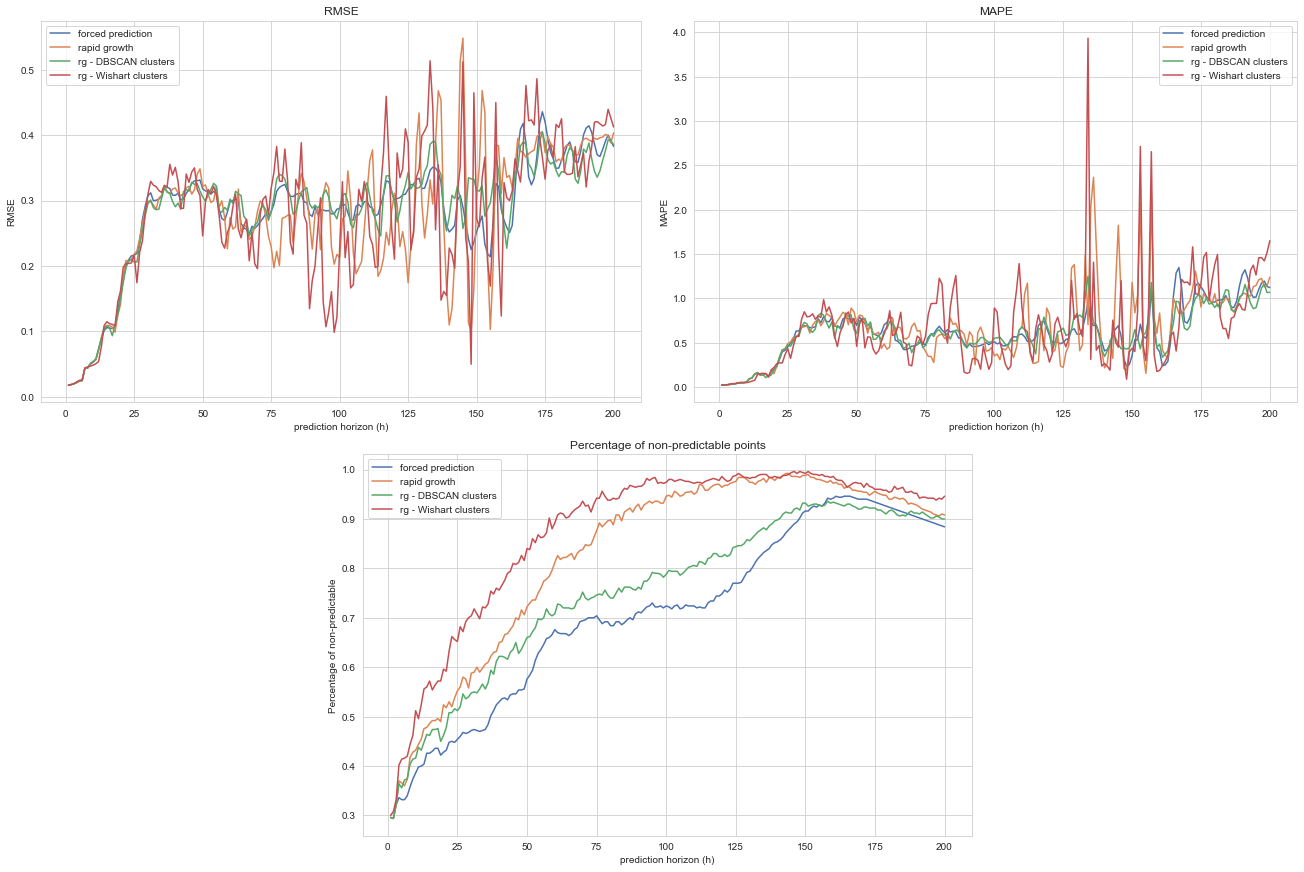

In [82]:
fig = plot_experiment_results(ROOT_PATH + 'results/predictions/check base algorithm on h=200, test_size=500',\
    ['fp', 'rg', 'rd', 'rw'], 200, 500, \
    ['forced prediction', 'rapid growth', 'rg - DBSCAN clusters', 'rg - Wishart clusters'], \
    'Metrics for base algoritm, test set size = 500, up_method - mean of max DBSCAN cluster, beta=20%')

In [18]:
fig.savefig('200.jpg')

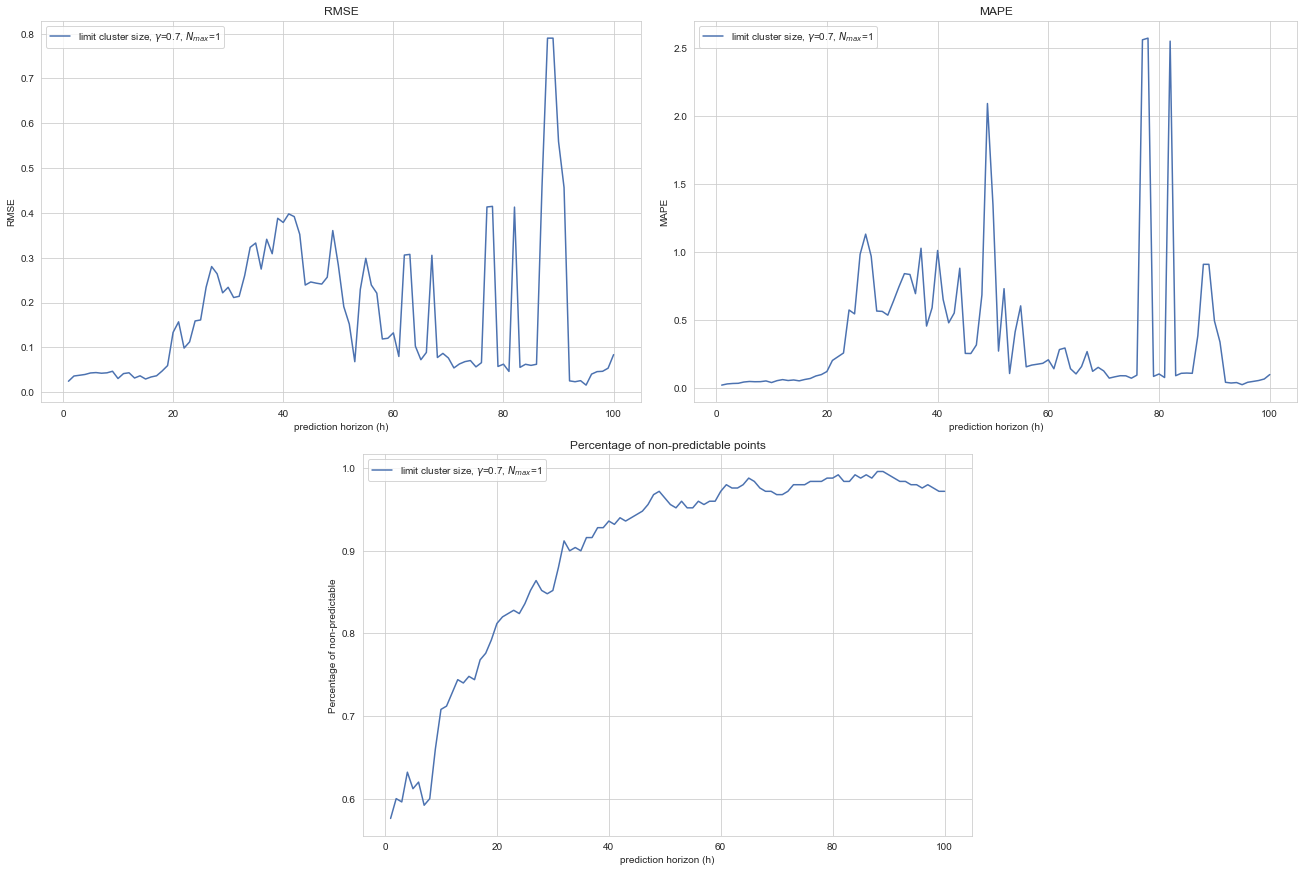

In [199]:
exp_short_names = ['cs_0.7_n_1']
exp_names = [r'limit cluster size, $\gamma$=0.7, $N_{max}$=1', r'limit cluster size, $\gamma$=0.1, $N_{max}$=2', r'limit cluster size, $\gamma$=0.2, $N_{max}$=2']
fig = plot_experiment_results(\
    working_directory=ROOT_PATH + 'results/predictions/05.06-13/find best base algorithm/n_iterations 250/',\
    exp_short_names=exp_short_names, \
    h_max=100, n_iterations=250, \
    exp_names=exp_names, \
    fig_title='Metrics for base algoritm, test set size = 250, up_method - mean of max DBSCAN cluster, beta=20%')

In [117]:
fig.savefig('max_cluster70-1-2-5.jpg')

AttributeError: 'dict' object has no attribute 'savefig'

### Thrown points experiment graphs

In [200]:
with open(ROOT_PATH + 'results/predictions/thrown_points_exp_m20_step5/predictions_wp.dat', 'wb') as f:
    for thrown in range(1, 100, 5):
        with open(ROOT_PATH + 'results/predictions/05.12-19/wp/thrown_wp_' + str(thrown) + '.dat', 'rb') as f1:
            th = pickle.load(f1)
            pickle.dump(th, f)
            up = pickle.load(f1)
            pickle.dump(up, f)
            n_iter = pickle.load(f1)
            pickle.dump(n_iter, f)

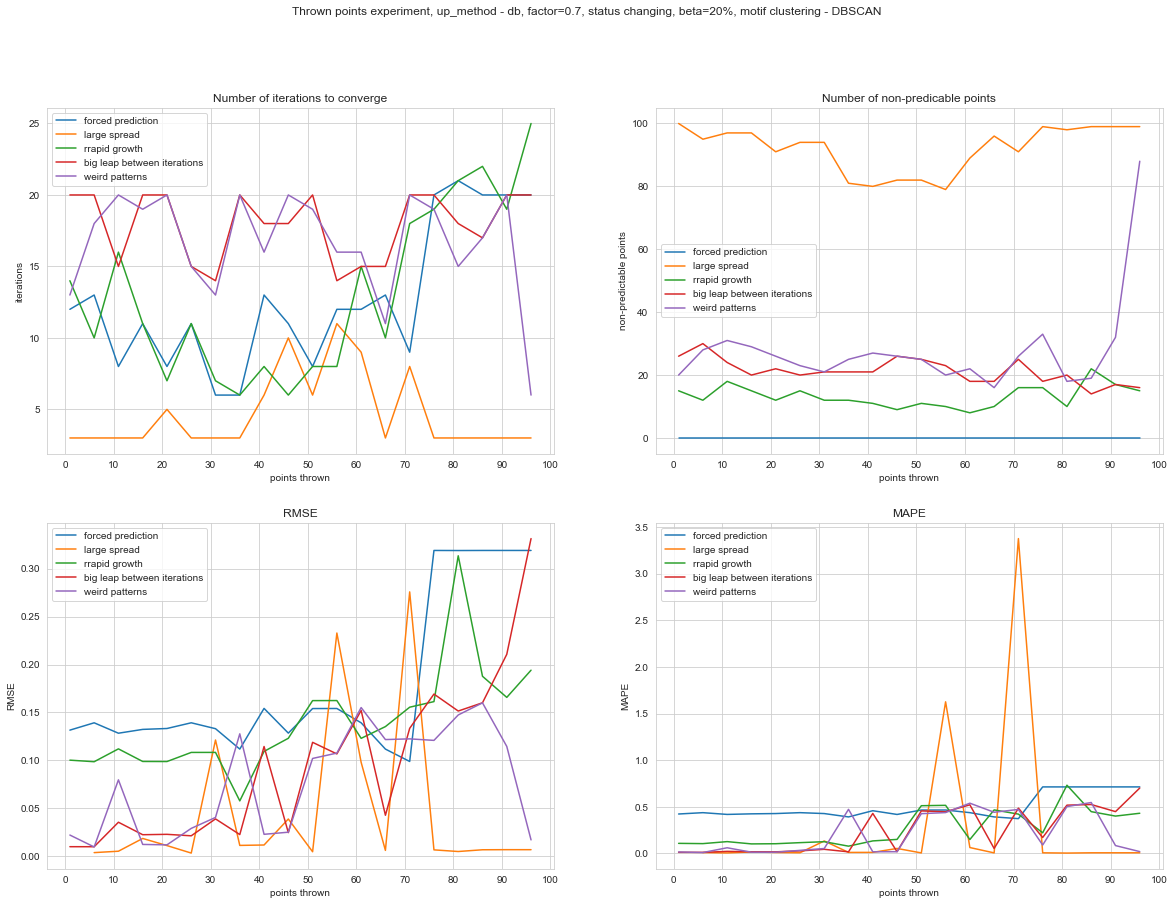

In [202]:
fig = plot_thrown_points_exp_results(ROOT_PATH + 'results/predictions/thrown_points_exp_m20_step5/', \
    ['fp', 'ls', 'rg', 'blbi', 'wp'], 100, ['forced prediction', 'large spread', 'rrapid growth', 'big leap between iterations', 'weird patterns'], \
    'Thrown points experiment, up_method - db, factor=0.7, status changing, beta=20%, motif clustering - DBSCAN', pointplot=False)

In [196]:
fig.savefig('thrown_points_exp_j_dist_j_dist_factor_pw_pw_fixed.jpg')

## Test healing 5% thrown points

In [8]:
true_points_5_thrown = np.array(Y2[:100], dtype=object)
true_points_5_thrown[[4, 44, 59, 90, 94]] = 'N'

In [17]:
with open(ROOT_PATH + 'code/logs_db_db_wfactor09_weirdpateps007_lcs_01_20.dat', 'rb') as f:
    up_logs = pickle.load(f)
    pp_logs = pickle.load(f)
    non_pred_logs = pickle.load(f)

h = 100
# true_points = true_points_5_thrown[:100]
true_points = up_logs[0]

[ 5 45 60 91 95]


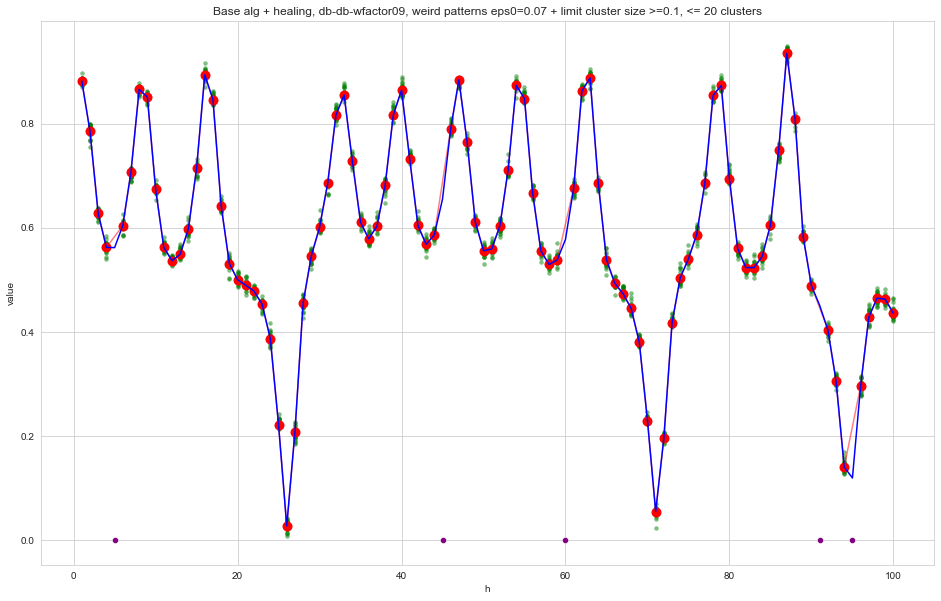

[21 22 23 24 25 26 27 28 29 30 31 70 71 72 75 76 77]
[21 22 23 24 25 26 27 28 29 70 71 72 75 76 77]
[20 21 22 23 24 25 26 70 71 72 75 76 77]
[20 21 22 23 24 25 26 70 71 72 75 76 77]
[20 21 22 23 24 70 71 72 75 76 77]
[20 21 22 23 24 70 71 72 75 76 77]
[20 21 22 23 24 70 71 72 75 76 77]


In [18]:
plot_healing_animation(None, Y2[:100], \
    title='Base algorithm + self-healing, db-db-wfactor07, weird patterns eps0=0.07 + limit cluster size >=0.1, <= 20 clusters', \
    saveanim_path='anim_db_db_wfactor09_weirdpateps007_lcs_01_20.gif', \
    up_logs=up_logs, pp_logs=pp_logs, true_points=true_points)

98 20
260 98
495 260
736 495
972 736
1204 972


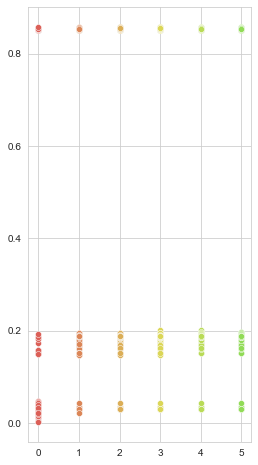

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 8))
color_palette = sns.color_palette('hls', 20)
sns.scatterplot(x=[0] * len(pp_logs[0][25]), y=pp_logs[0][25], color=color_palette[0], ax=ax)
for i in range(len(pp_logs[1:]) - 1):
    y = pp_logs[i + 1][25]
    y = y[len(pp_logs[i][25]):]
    print(len(pp_logs[i+1][25]), len(pp_logs[i][25]))
    sns.scatterplot(x=[i] * len(y), y=y, color=color_palette[i], ax=ax)

plt.show()

In [28]:
errors_ds = pd.DataFrame(columns=['alg_name', 'RMSE', 'MAPE', 'non_pred'])

In [31]:
with open(ROOT_PATH + 'results/predictions/five_thrown_experiments/logs_rd_pointwise_weights_f0.8.dat', 'rb') as f:
    up_logs = pickle.load(f)
    pp_logs = pickle.load(f)
    non_pred_logs = pickle.load(f)

predictable = np.argwhere(up_logs[-1] != 'N').reshape(1, -1)[0]

errors_ds = errors_ds.append({
    'alg_name' : 'mc_method: db; up_method: db + pointwise weights f=0.8; noise cleared',
    'RMSE' : np.sqrt(mean_squared_error(np.take(Y2, predictable), \
        np.take(up_logs[-1], predictable).astype(float))),
    'MAPE' : mean_absolute_percentage_error(np.take(Y2, predictable), \
        np.take(up_logs[-1], predictable).astype(float)),
    'non_pred' : len(predictable) / 100
}, ignore_index=True)

In [32]:
errors_ds

,alg_name,RMSE,MAPE,non_pred
0,mc_method: db; up_method: db + pointwise weigh...,0.124303,0.405309,0.93
1,mc_method: db; up_method: db + pointwise weigh...,0.125590,0.413919,0.91
2,mc_method: db; up_method: db + pointwise weigh...,0.128269,0.427327,0.90


In [33]:
errors_ds.to_csv(ROOT_PATH + 'results/graphs/04.01-07/errors.csv')

In [189]:
to_f = open(ROOT_PATH + 'results/predictions/04.15-21/predictions_j_dist_factor.dat', 'wb')
for k in [1, 6, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66]:
    filename = ROOT_PATH + 'results/predictions/04.15-21/wi_db_j_dist_factor/log_' + str(k) + '.dat'
    with open(filename, 'rb') as f:
        thrown = pickle.load(f)
        unified_preds = pickle.load(f)
        n_iterations = pickle.load(f)
        pickle.dump(thrown, to_f)
        pickle.dump(unified_preds, to_f)
        pickle.dump(n_iterations, to_f)
to_f.close()

## See where exactly wrong clusters come from

In [65]:
# load logs
# (pattern, motifs, pieces)
with open(ROOT_PATH + 'results/predictions/04.15-21/clustered_motifs_with_pieces.dat', 'rb') as f:
    clustered_motifs_with_pieces = pickle.load(f)

# (val, j, pattern)
with open(ROOT_PATH + 'results/predictions/04.08-14/patterns_question/initial_algorithm/logs_23.dat', 'rb') as f:
    logs_23 = pickle.load(f)

with open(ROOT_PATH + 'results/predictions/04.08-14/patterns_question/initial_algorithm/label_mapping.dat', 'rb') as f:
    label_mapping = pickle.load(f)

In [132]:
with open(ROOT_PATH + 'results/predictions/04.08-14/patterns_question/initial_algorithm/logs_db_db_rd_pw_f0.4_noise_fixed_points.dat', 'rb') as f:
    up_logs = pickle.load(f)
    _ = pickle.load(f)
    _ = pickle.load(f)

In [80]:
import math

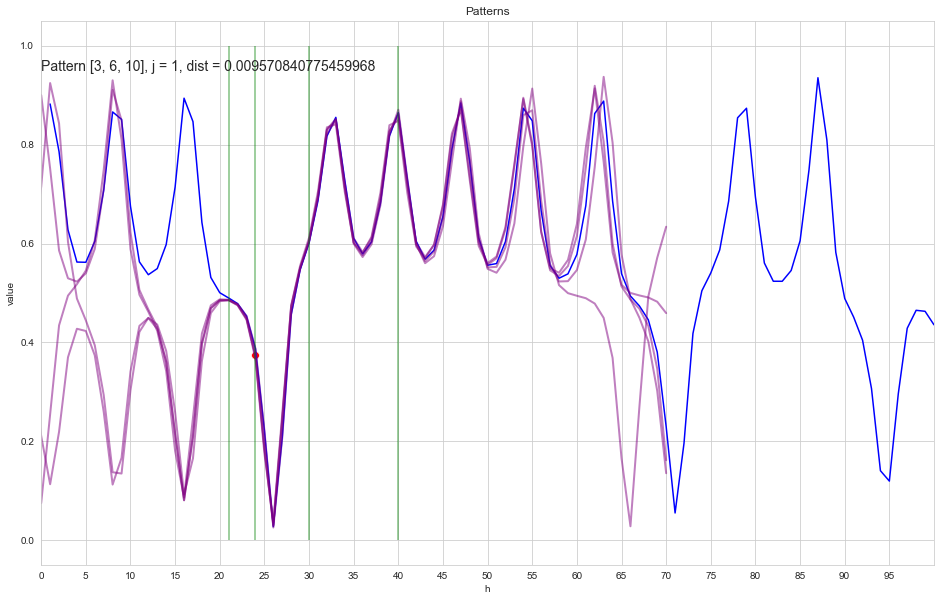

In [136]:
logs_23_0 = logs_23[4]
fig_directory = ROOT_PATH + 'results/graphs/04.15-21/pieces_expolring/iteration_4_dist/'
up_logs_4 = up_logs[4]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))
camera = Camera(fig)
motifs = [c[1] for c in clustered_motifs_with_pieces]
ticks = list(range(0, h, 5))
for i in range(len(logs_23_0)):
    val, j, pattern = logs_23_0[i]
    cluster = label_mapping[400 + 23].get(val)
    
    cm_with_pieces_for_pattern = list(filter(lambda x: (x[0] == pattern).all(), clustered_motifs_with_pieces))[0]
    
    motifs = cm_with_pieces_for_pattern[1]

    # dist


    if cluster == 0:
        # Y2
        sns.lineplot(x=list(range(1, 101)), y=Y2[:100], color='blue', ax=ax)

        our_motif_idx = -1  
        for k in range(len(motifs)):
            if math.isclose(motifs[k][j], val):
                our_motif_idx = k
                break
        cm_pieces = cm_with_pieces_for_pattern[2][our_motif_idx]
        for k in range(len(cm_pieces)):
            yp = Y1[cm_pieces[k][0]:cm_pieces[k][1] + 1]
            xp = list(range(len(yp)))
            center = sum(pattern[:j]) + 30 - 24
            xp = [v - center for v in xp]
            sns.lineplot(x=xp, y=yp, color='purple', linewidth=2, alpha=0.5, ax=ax)
        title = f'Patterns'
        i_pattern = [23] * 4
        for k in range(j):
            i_pattern[k] -= sum(pattern[k:j])
        for k in range(j+1, 4):
            i_pattern[k] += sum(pattern[j:k])
        i_pattern_display = [k + 1 for k in i_pattern]
        real_vals = np.take(up_logs_4, i_pattern)
        real_vals = np.delete(real_vals, j)
        # print(pattern, j, real_vals, motifs[our_motif_idx])
        dist = np.linalg.norm(real_vals - np.delete(motifs[our_motif_idx], j))

        ax.vlines(i_pattern_display, color='green', ymin=0, ymax=1, alpha=0.5)
        sns.scatterplot(x=[24], y=[val], color='red', s=60, ax=ax)
        
        ax.set(xlabel='h', ylabel='value', xticks=ticks, title=title, xlim=[0, 100])
        ax.text(0, 0.95, f'Pattern {pattern.tolist()}, j = {j}, dist = {dist}', fontsize=14)
        camera.snap()

anim = camera.animate(blit=True, interval=2000, repeat=True, repeat_delay=2000)
anim.save(fig_directory + 'pattern_and_time_series_pieces_cluster0.gif')


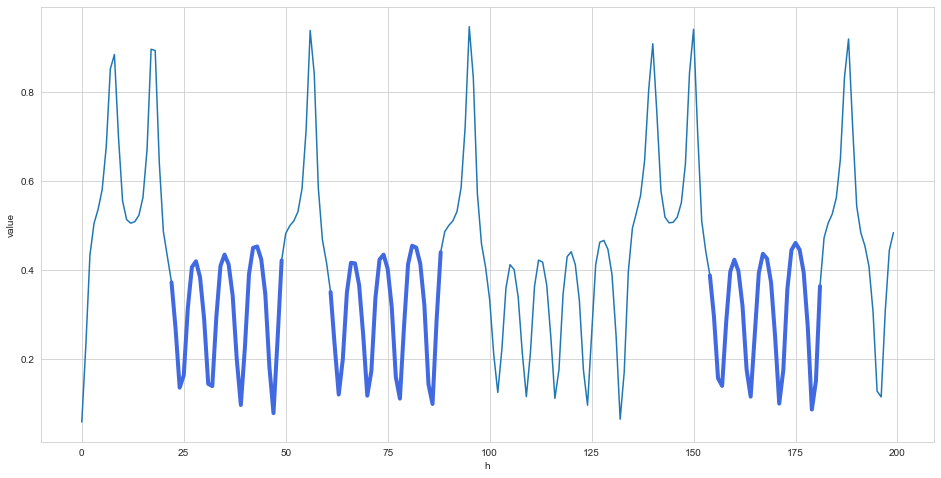

In [146]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
sns.lineplot(x=range(200), y=Y1[:200], ax=ax)
ax.set(xlabel='h', ylabel='value', yticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0])
pieces = [22, 50, 61, 89, 154, 182]
for i in [0, 2, 4]:
    sns.lineplot(x=range(pieces[i], pieces[i+1]), y=Y1[pieces[i]:pieces[i+1]], color='royalblue', linewidth=4, ax=ax)

[[<matplotlib.axis.XTick at 0x7f8a80da7c70>,
 Text(0, 0.5, 'value')]

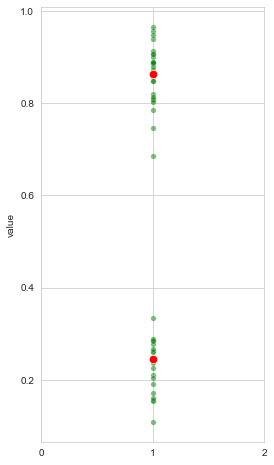

In [157]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 8))
clusters = [0.24] * 20 + [0.86] * 30
clusters = np.array(clusters)
clusters += np.random.normal(0, 0.05, size=50)
sns.scatterplot(x=[1] * 50, y=clusters, color='g', alpha=0.5, ax=ax, s=30)
sns.scatterplot(x=[1] *2, y=[0.2452, 0.8634], color='r', ax=ax, s=70)
ax.set(xticks=[0, 1, 2], ylabel='value')

<AxesSubplot:xlabel='h', ylabel='value'>

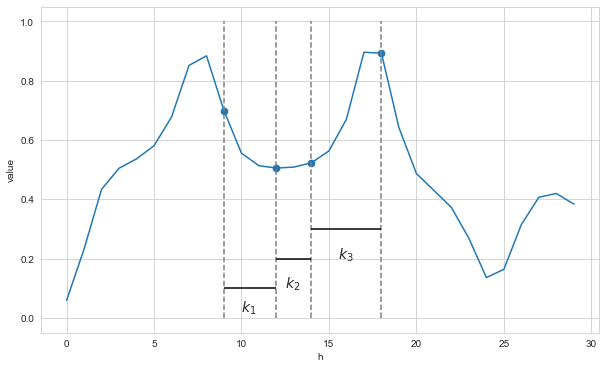

In [180]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.lineplot(x=range(30), y=Y1[:30], ax=ax)
ax.set(xlabel='h', ylabel='value', yticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0])
pattern = [9, 12, 14, 18]
ax.vlines(pattern, ymin=0.0, ymax=1.0, linestyles='dashed', color='grey')
ax.hlines(0.1, xmin=9, xmax=12, color='k')
ax.text(10, 0.02, r'$k_1$', fontsize=14)
ax.hlines(0.2, xmin=12, xmax=14, color='k')
ax.text(12.5, 0.1, r'$k_2$', fontsize=14)
ax.hlines(0.3, xmin=14, xmax=18, color='k')
ax.text(15.5, 0.2, r'$k_3$', fontsize=14)

sns.scatterplot(x=[9, 12, 14, 18], y=[Y1[9], Y1[12], Y1[14], Y1[18]], s=70)

## For paper

[Text(0.5, 1.0, 'title'), Text(0, 0.5, 'value'), Text(0.5, 0, 'h')]

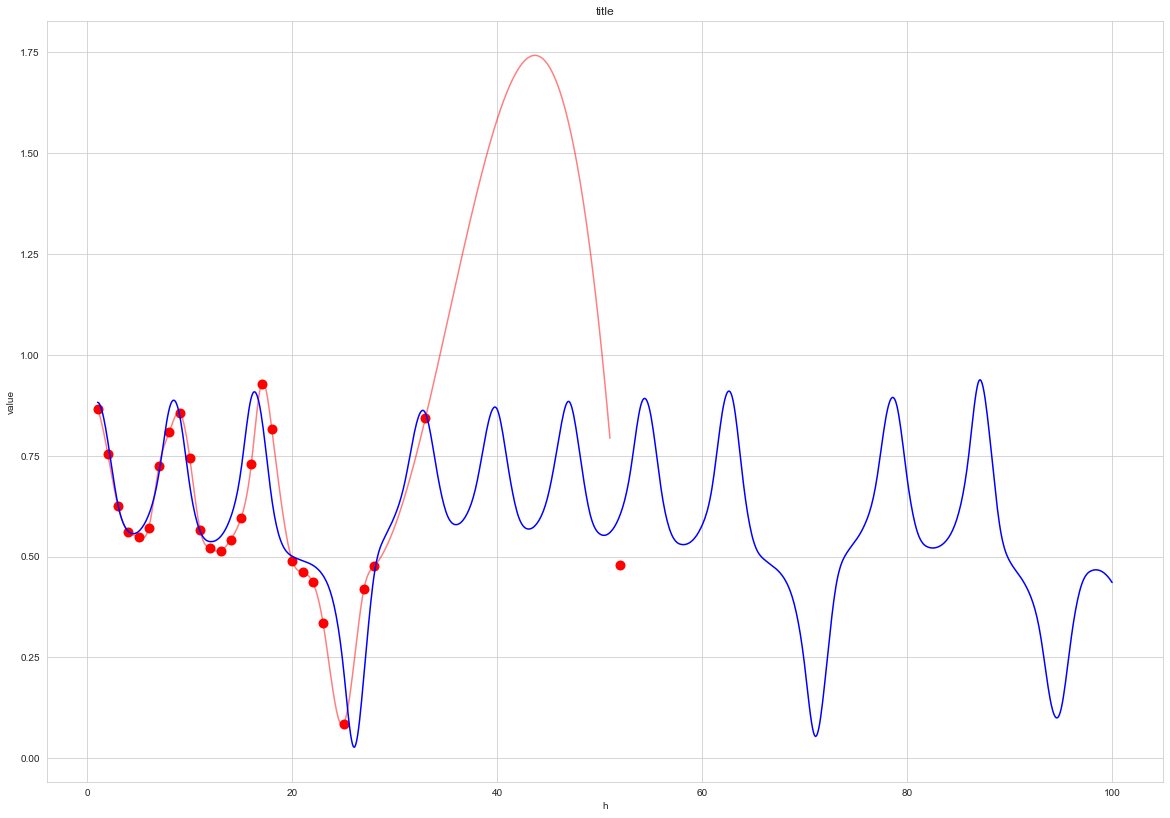

In [27]:
with open(ROOT_PATH + 'code/logs_real_prediction_tp_rd_wi_basealg_jdistfactor.dat', 'rb') as f:
    up_logs = pickle.load(f)
    pp_logs = pickle.load(f)

up = up_logs[0]
pp = pp_logs[0]
fig, ax = plt.subplots(1, 1, figsize=(20, 14))
h = len(up)
x = list(range(1, h + 1))
predictable = np.argwhere(up != 'N').reshape(1, -1)[0]
x = np.take(x, predictable)
y = np.take(up, predictable)
y = y.astype(float)
non_pred = np.argwhere(up == 'N').reshape(1, -1)[0] + 1
pred = np.argwhere(up != 'N').reshape(1, -1)[0]

sns.scatterplot(x=x, y=y, color='red', ax=ax, linewidth=0, s=100)
interp = interp1d(x=x, y=y, kind='cubic')
xi = np.linspace(1, pred[-1], 1000)
yi = interp(xi)
sns.lineplot(x=xi, y=yi, color='red', ax=ax, alpha=0.5)
interp = interp1d(x=list(range(1, h+1)), y=Y2[:h], kind='cubic')
xi_true = np.linspace(1, 100, 1000)
yi_true = interp(xi_true)
sns.lineplot(x=xi_true, y=yi_true, ax=ax, color='blue')

ax.set(title='title', ylabel='value', xlabel='h')

[  1   4   6  11  14  16  21  22  23  24  25  26  27  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100]


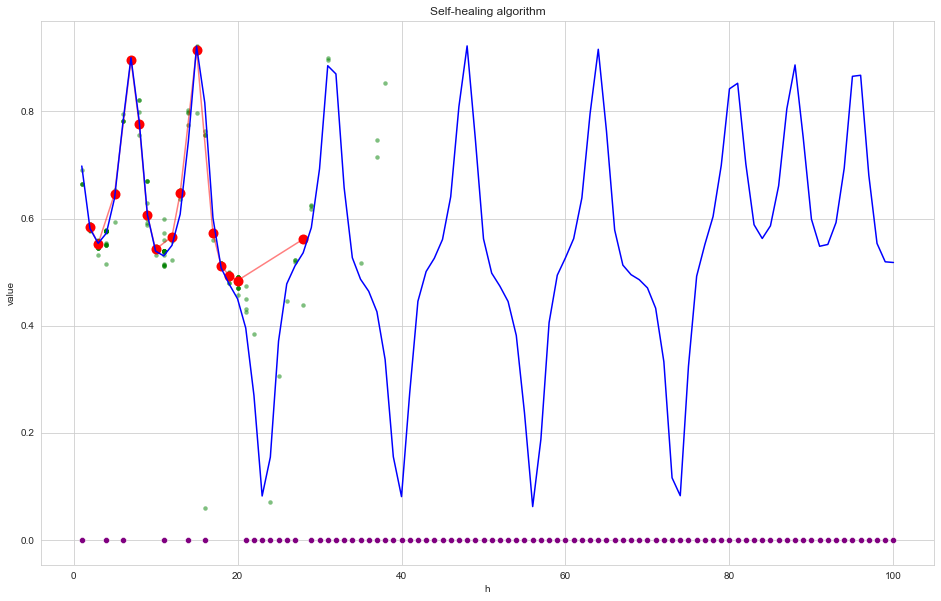

[ 22  23  24  25  26  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100]
[ 22  23  24  25  26  30  32  34  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100]
[ 22  23  24  26  28  29  37  39  41  42  43  44  45  46  47  48  49  50
  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100]
[ 22  23  24  26  28  29  37  39  41  42  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  

In [14]:
with open(ROOT_PATH + 'code/logs_real_pred.dat', 'rb') as f:
    up = pickle.load(f)
    pp = pickle.load(f)

plot_healing_animation(None, Y2[135:235],\
    title='Self-healing algorithm', 
    saveanim_path='anim.gif',
    up_logs=up,
    pp_logs=pp
    )

## "Main experiment" - on test size 5

In [44]:
from itertools import product

In [48]:
def plot_errors_skips(rmses, mapes, non_preds, hs, exp_names=[], fig_title=''):
    '''Plot function for errors

    Parameters
    ----------
    rmses: list of lists
        List of RMSE lists for each experiment in comparison
    mapes: list of lists
        List of MAPE -//-
    non_preds: list of lists
        List of percentage of non-predictable points -//-
    '''
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(27, 6))
    n_experiments = len(rmses)
    x = hs
    colors = sns.color_palette('deep', 10)
    if len(exp_names) == 0:
        exp_names = [''] * n_experiments
    for i in range(n_experiments):
        sns.lineplot(x=x, y=rmses[i], color=colors[i], ax=axs[0], label=exp_names[i])
        sns.lineplot(x=x, y=mapes[i], color=colors[i], ax=axs[1], label=exp_names[i])
        sns.lineplot(x=x, y=non_preds[i], color=colors[i], ax=axs[2], label=exp_names[i])
    
    axs[0].set(xlabel='prediction horizon (h)', ylabel='RMSE', title='RMSE')
    axs[1].set(xlabel='prediction horizon (h)', ylabel='MAPE', title='MAPE')
    axs[2].set(xlabel='prediction horizon (h)', ylabel='Percentage of non-predictable', title='Percentage of non-predictable points')
    fig.suptitle(fig_title)
    plt.show()

    return fig


def get_errors_from_prediction_matrix_skips(prediction_matrix, hs, tests, Y2, n_test_passed=131):
    h_max = hs[-1]
    n_iterations = prediction_matrix.shape[1]

    Y_true = Y2[n_test_passed:n_test_passed+tests[-1] + 1]
    Y_true = np.take(Y_true, tests)
    # print(Y_true, prediction_matrix[0])
    # print(len(Y_true), n_test_passed+n_iterations)

    rmse = []
    mape = []
    npr = []
    for k in range(len(hs)):
        unified_preds = prediction_matrix[k][:]
        predictable = np.argwhere(unified_preds != 'N')
        unified_preds_predicted = np.take(unified_preds, predictable).astype(float)
        if len(np.take(Y_true, predictable)) > 0:
            rmse.append(np.sqrt(mean_squared_error(np.take(Y_true, predictable), \
                unified_preds_predicted)))
            mape.append(mean_absolute_percentage_error(np.take(Y_true, predictable), \
                unified_preds_predicted))
            # rmse.append(calc_rmse(np.take(Y_true, predictable), unified_preds_predicted))
            # mape.append(calc_mape(np.take(Y_true, predictable), unified_preds_predicted))
        else:
            rmse.append(np.nan)
            mape.append(np.nan)
        npr.append(np.count_nonzero(unified_preds == 'N') / n_iterations)
    return rmse, mape, npr


def calc_rmse(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

def calc_mape(y_true, y_pred):
    m = 0
    for i in range(len(y_true)):
        m += abs(y_true[i] - y_pred[i]) / y_true[i]
    return m / len(y_true)

In [102]:
n_test_passed = 131
Y_true = Y2[n_test_passed:]
hs = [100]
tests = [i * 10 for i in range(5)]
args = list(product(hs, tests))

res = []

In [52]:
with open(ROOT_PATH + 'results/predictions/05.06-13/factor_gridsearch/pm_f_0.5.dat', 'rb') as f:
    pm = pickle.load(f)

rmse, mape, npr = get_errors_from_prediction_matrix_skips(pm, [5, 20], list(range(10)))
print(f'f=0.5 --> rmse: {rmse[1]:.3f}, mape: {mape[1]:.3f}, npr: {npr[1]:.2f}')

with open(ROOT_PATH + 'results/predictions/05.06-13/factor_gridsearch/pm_f_0.7.dat', 'rb') as f:
    pm = pickle.load(f)

rmse, mape, npr = get_errors_from_prediction_matrix_skips(pm, [5, 20], list(range(10)))
print(f'f=0.7 --> rmse: {rmse[1]:.3f}, mape: {mape[1]:.3f}, npr: {npr[1]:.2f}')

with open(ROOT_PATH + 'results/predictions/05.06-13/factor_gridsearch/pm_f_0.9.dat', 'rb') as f:
    pm = pickle.load(f)

rmse, mape, npr = get_errors_from_prediction_matrix_skips(pm, [5, 20], list(range(10)))
print(f'f=0.9 --> rmse: {rmse[1]:.3f}, mape: {mape[1]:.3f}, npr: {npr[1]:.2f}')

with open(ROOT_PATH + 'results/predictions/05.06-13/factor_gridsearch/pm_f_1.1.dat', 'rb') as f:
    pm = pickle.load(f)

rmse, mape, npr = get_errors_from_prediction_matrix_skips(pm, [5, 20], list(range(10)))
print(f'f=1.1 --> rmse: {rmse[1]:.3f}, mape: {mape[1]:.3f}, npr: {npr[1]:.2f}')

with open(ROOT_PATH + 'results/predictions/05.06-13/factor_gridsearch/pm_f_1.3.dat', 'rb') as f:
    pm = pickle.load(f)

rmse, mape, npr = get_errors_from_prediction_matrix_skips(pm, [5, 20], list(range(10)))
print(f'f=1.3 --> rmse: {rmse[1]:.3f}, mape: {mape[1]:.3f}, npr: {npr[1]:.2f}')

f=0.5 --> rmse: 0.012, mape: 0.014, npr: 0.40
f=0.7 --> rmse: 0.006, mape: 0.008, npr: 0.30
f=0.9 --> rmse: 0.014, mape: 0.014, npr: 0.30
f=1.1 --> rmse: 0.015, mape: 0.015, npr: 0.40
f=1.3 --> rmse: 0.015, mape: 0.015, npr: 0.40


In [99]:
with open(ROOT_PATH + 'results/predictions/05.06-13/weird_patterns healing/pm100_eps0_0.05.dat', 'rb') as f:
    pm005 = pickle.load(f)

rmse, mape, npr = get_errors_from_prediction_matrix_skips(pm005, [100], list(range(0, 100, 10)))
print(f'eps0=0.05 --> rmse: {rmse[0]:.3f}, mape: {mape[0]:.3f}, npr: {npr[0]:.2f}')

with open(ROOT_PATH + 'results/predictions/05.06-13/weird_patterns healing/pm100_eps0_0.1.dat', 'rb') as f:
    pm01 = pickle.load(f)

rmse, mape, npr = get_errors_from_prediction_matrix_skips(pm01, [100], list(range(0, 100, 10)))
print(f'eps0=0.1 --> rmse: {rmse[0]:.3f}, mape: {mape[0]:.3f}, npr: {npr[0]:.2f}')

eps0=0.05 --> rmse: 0.089, mape: 0.133, npr: 0.50
eps0=0.1 --> rmse: 0.253, mape: 0.223, npr: 0.20


In [100]:
pm005

array([[0.5832613401926919, 'N', 0.6675591787367864, 0.4950354902771829,
        0.5995210044771461, 0.8738383772430826, 'N', 'N', 'N', 'N']],
      dtype=object)

In [125]:
with open('logs_test.dat', 'rb') as f:
    while True:
        try:
            (h, test_i) = pickle.load(f)
            up = pickle.load(f)
            print(h, test_i, up)
        except EOFError:
            break

4 0 0.607998386494894
4 1 N
5 0 0.607998386494894
5 1 N


In [111]:
logs = []
with open(ROOT_PATH + 'results/predictions/05.06-13/weird_patterns healing/logs_eps0_0.05.dat', 'rb') as f:
    while True:
        try:
            log = pickle.load(f)
            logs.append(log)
        except EOFError:
            break

start_points = list(range(0, 100, 10))
for i in range(len(start_points)):
    Y_true = Y2[131+start_points[i]:131+start_points[i]+100]
    predictable = np.argwhere(logs[i] != 'N')
    unified_preds_predicted = np.take(logs[i], predictable).astype(float)
    print(f'rmse: {np.sqrt(mean_squared_error(np.take(Y_true, predictable), unified_preds_predicted)):.2f}')
    print(f'mape: {mean_absolute_percentage_error(np.take(Y_true, predictable), unified_preds_predicted):.2f}')
    print(f'nonp: {1 - len(predictable) / 100:.2f}\n')

rmse: 0.26
mape: 0.55
nonp: 0.47

rmse: 0.27
mape: 0.58
nonp: 0.47

rmse: 0.27
mape: 0.64
nonp: 0.53

rmse: 0.27
mape: 0.63
nonp: 0.52

rmse: 0.27
mape: 0.69
nonp: 0.52

rmse: 0.30
mape: 0.74
nonp: 0.55

rmse: 0.32
mape: 0.77
nonp: 0.44

rmse: 0.29
mape: 0.51
nonp: 0.90

rmse: 0.30
mape: 0.38
nonp: 0.88

rmse: 0.29
mape: 0.44
nonp: 0.98



In [51]:
print(list(range(0, 10 * 10, 10)))

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]


[]


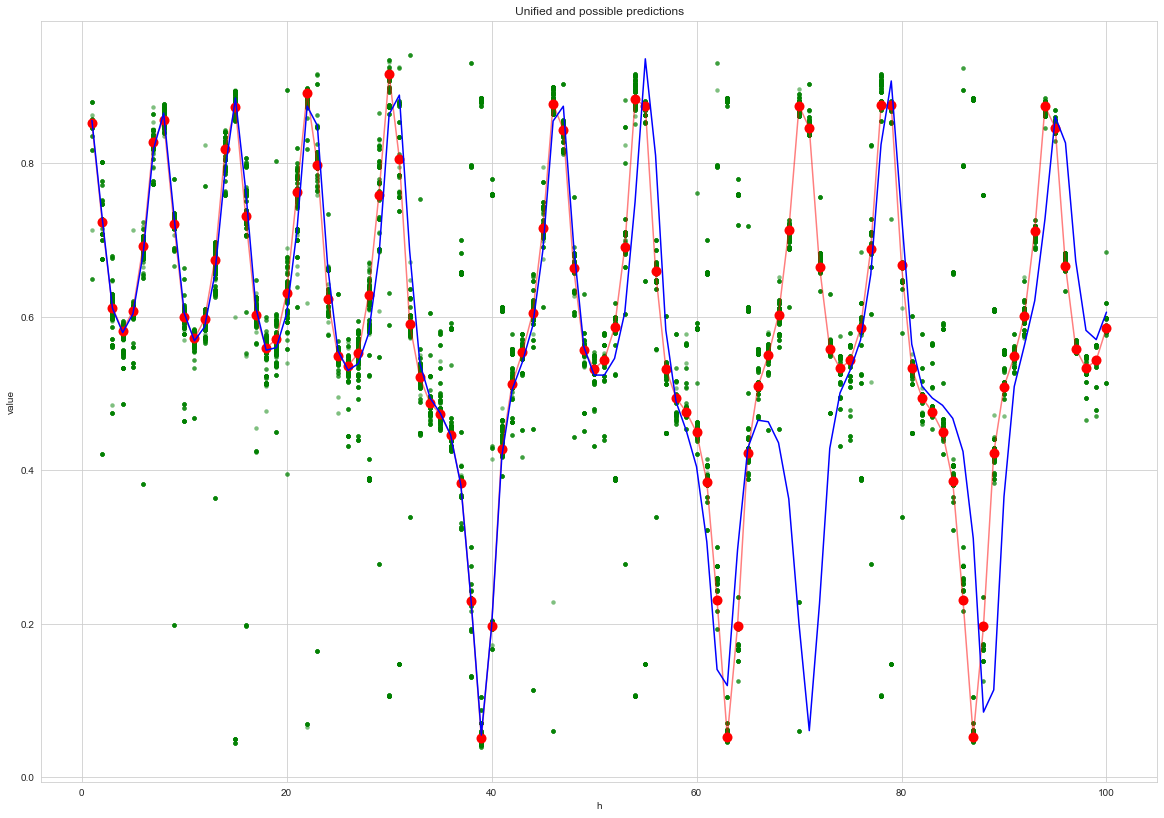

[]


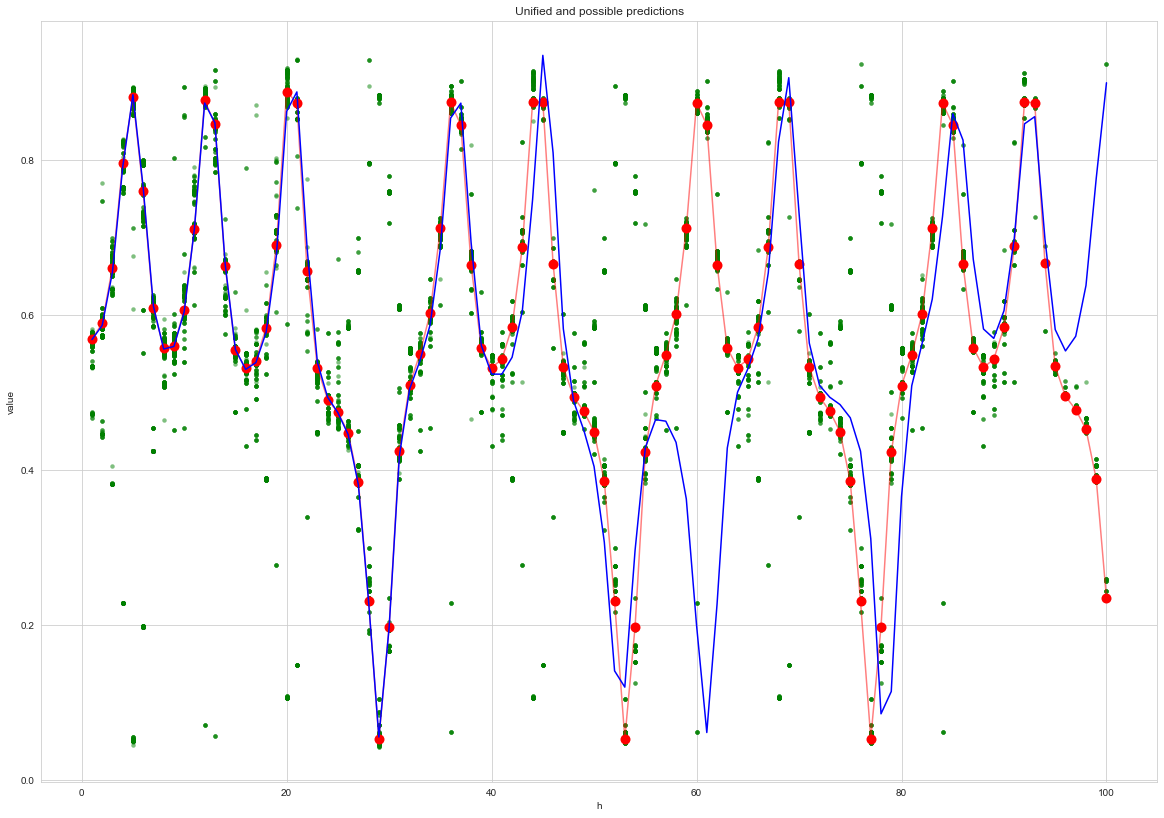

[]


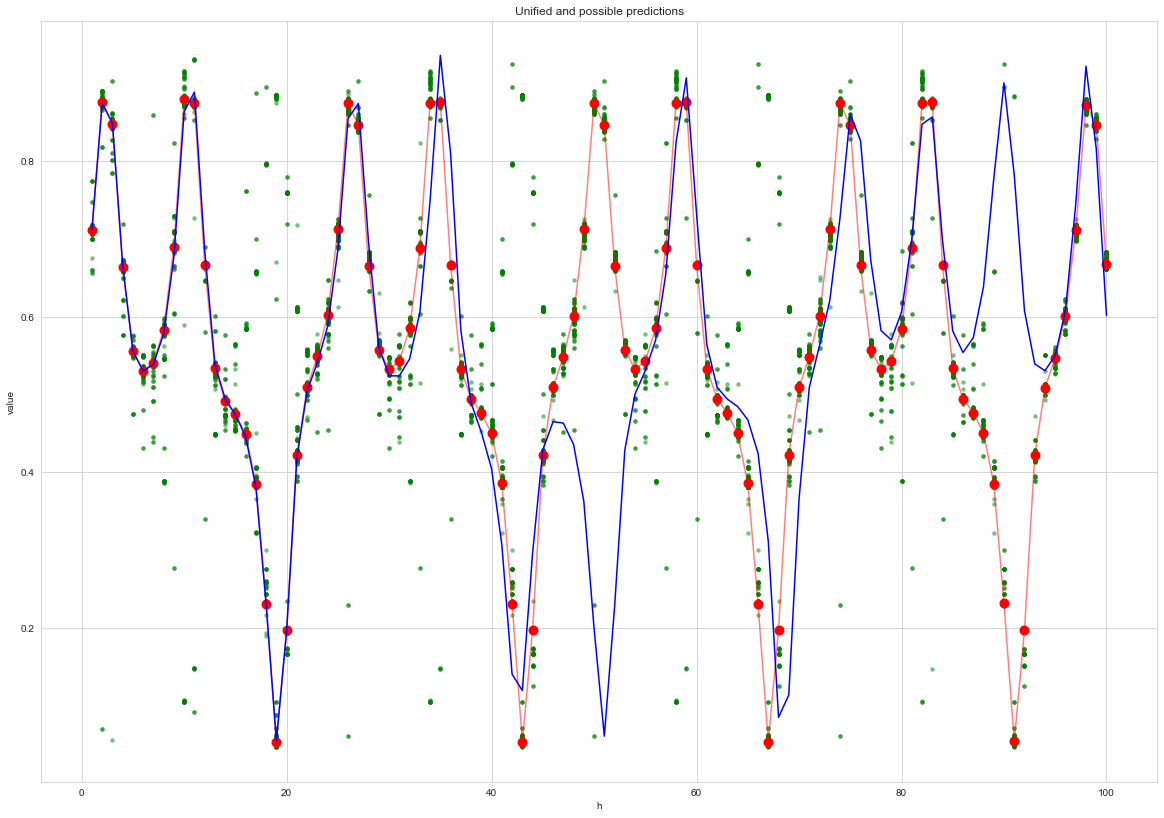

[]


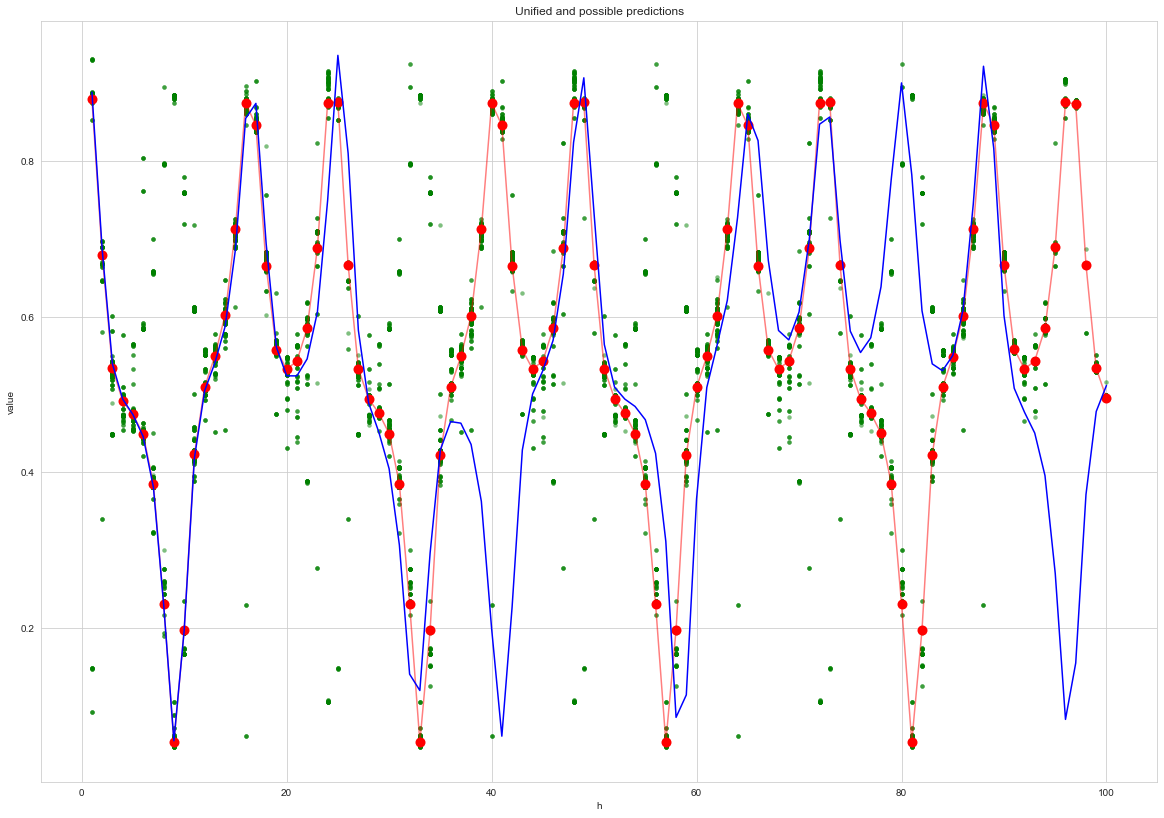

[]


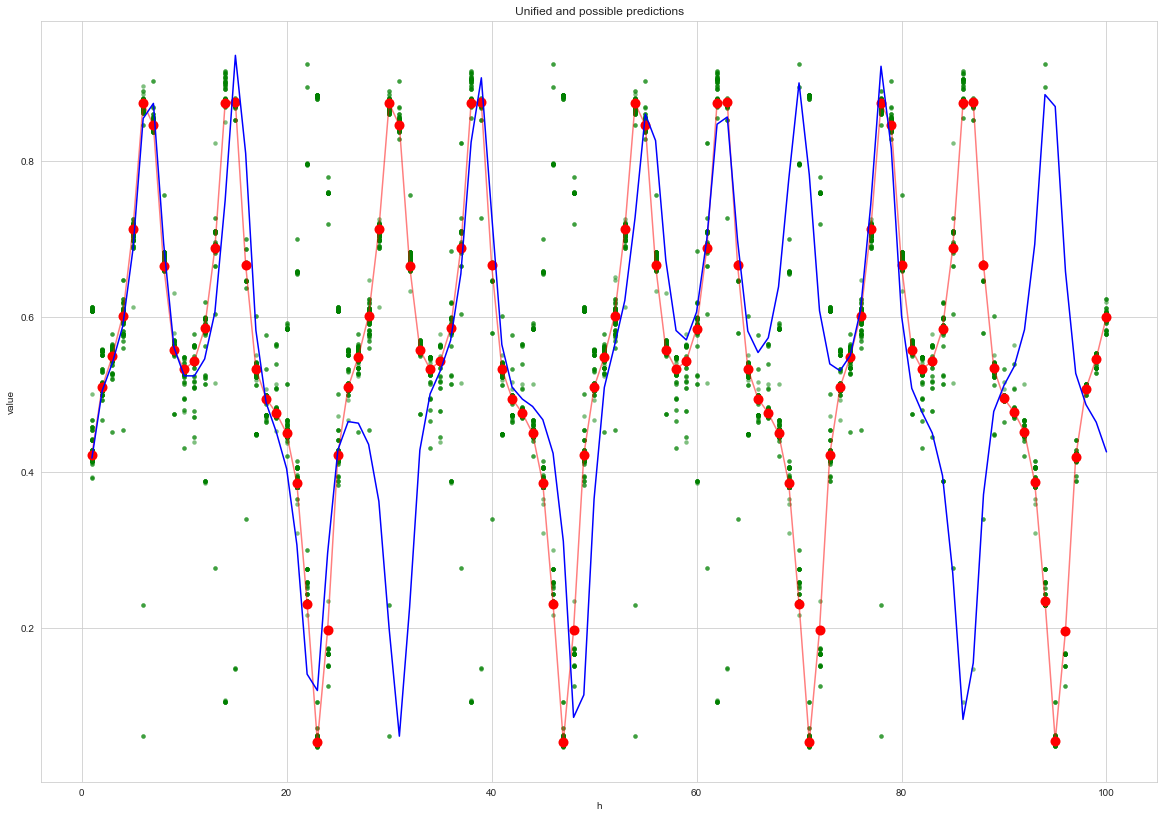

In [103]:
exp_name = 'f09_bl_lcs01_20'
for (h0, i0) in args:
    with open(ROOT_PATH + 'results/predictions/04.22-28/' + exp_name + \
        '/logs_h_' + str(h0) + '_test_i_' + str(i0) + '.dat', 'rb') as f:
        up = pickle.load(f) 
        pp = pickle.load(f)

    Y_true0 = Y2[i0 + n_test_passed - h0 + 1:i0 + n_test_passed + 1]
    Y_preceding = Y2[:i0 + n_test_passed - h0 + 1]
    # print(Y_true0, Y_preceding, Y2[20:40])

    predictable = np.argwhere(up != 'N')
    unified_preds_predicted = np.take(up, predictable).astype(float)
    if len(np.take(Y_true, predictable)) > 0:
        rmse = np.sqrt(mean_squared_error(np.take(Y_true0, predictable), \
            unified_preds_predicted))
        mape = mean_absolute_percentage_error(np.take(Y_true0, predictable), \
            unified_preds_predicted)
    else:
        rmse = np.nan
        mape = np.nan
    npr = np.count_nonzero(up == 'N') / 100

    res.append({
        'exp_name' : exp_name,
        'test_i' : i0,
        'rmse' : rmse,
        'mape' : mape,
        'npr' : npr
    })

    plot_unified_and_possible_preds(up, pp, Y_true0)

In [100]:
res

,exp_name,test_i,rmse,mape,npr
0,f09dists_bl_lcs01_20,0,0.137776,0.318553,0.0
1,f09dists_bl_lcs01_20,10,0.158155,0.328632,0.0
2,f09dists_bl_lcs01_20,20,0.179670,0.349037,0.0
3,f09dists_bl_lcs01_20,30,0.216616,0.524992,0.0
4,f09dists_bl_lcs01_20,40,0.248088,0.563664,0.0
5,f09_bl_lcs01_20,0,0.137796,0.318698,0.0
6,f09_bl_lcs01_20,10,0.158155,0.328632,0.0
7,f09_bl_lcs01_20,20,0.179670,0.349037,0.0
8,f09_bl_lcs01_20,30,0.216616,0.524992,0.0
9,f09_bl_lcs01_20,40,0.248088,0.563664,0.0


In [99]:
res = pd.DataFrame(res)

In [91]:
res['rmse'] = list(map(lambda x : round(x, 2), res['rmse']))

In [92]:
res['mape'] = list(map(lambda x : round(x, 2), res['mape']))

In [104]:
res

[{'exp_name': 'f09_bl_lcs01_20',
  'test_i': 0,
  'rmse': 0.1377956965063853,
  'mape': 0.3186975915076917,
  'npr': 0.0},
 {'exp_name': 'f09_bl_lcs01_20',
  'test_i': 10,
  'rmse': 0.15815472467405048,
  'mape': 0.3286323748219157,
  'npr': 0.0},
 {'exp_name': 'f09_bl_lcs01_20',
  'test_i': 20,
  'rmse': 0.17967043157042623,
  'mape': 0.3490367949388882,
  'npr': 0.0},
 {'exp_name': 'f09_bl_lcs01_20',
  'test_i': 30,
  'rmse': 0.21661558709874504,
  'mape': 0.5249918448852937,
  'npr': 0.0},
 {'exp_name': 'f09_bl_lcs01_20',
  'test_i': 40,
  'rmse': 0.24808761778847505,
  'mape': 0.5636636321002946,
  'npr': 0.0}]

In [187]:
pm = np.empty((6, 20), dtype=object)
h_dict = {1 : 0, 5 : 1, 20 : 2, 50 : 3, 70 : 4, 100 : 5}
with open('/Users/nastya/Downloads/logs_05_1-5.dat', 'rb') as f:
    while True:
        try:
            h, test_i = pickle.load(f)
            up = pickle.load(f)
            if test_i < 20:
                pm[h_dict[h], test_i] = up
        except EOFError:
            break

In [188]:
with open(ROOT_PATH + 'code/logs_05_1_100.dat', 'rb') as f:
    while True:
        try:
            h, test_i = pickle.load(f)
            up = pickle.load(f)
            if test_i < 20:
                pm[h_dict[h], test_i] = up
        except EOFError:
            break

In [193]:
pm[-1][9:] = 'N'

In [224]:
res_05_1_wp = get_errors_from_prediction_matrix_skips(pm, [1, 5, 20, 50, 70, 100], list(range(20)))

In [225]:
with open(ROOT_PATH + 'results/predictions/05.06-13/find best base algorithm/n_iterations 250/pm_cs_0.7_n_2.dat', 'rb') as f:
    pm_rd = pickle.load(f)
pm_rd1 = np.empty((6, 20), dtype=object)

for h in [1, 5, 20, 50, 70, 100]:
    for test_i in range(20):
        pm_rd1[h_dict[h], test_i] = pm_rd[h, test_i]

res_rd_07_2 = get_errors_from_prediction_matrix_skips(pm_rd1, [1, 5, 20, 50, 70, 100], list(range(20)), n_test_passed=131)

In [226]:
with open(ROOT_PATH + 'results/predictions/05.06-13/find best base algorithm/n_iterations 250/pm_cs_0.5_n_1.dat', 'rb') as f:
    pm_rd = pickle.load(f)
pm_rd_05_1 = np.empty((6, 20), dtype=object)

for h in [1, 5, 20, 50, 70, 100]:
    for test_i in range(20):
        pm_rd_05_1[h_dict[h], test_i] = pm_rd[h, test_i]

res_rd_05_1 = get_errors_from_prediction_matrix_skips(pm_rd_05_1, [1, 5, 20, 50, 70, 100], list(range(20)), n_test_passed=131)

In [175]:
rmse, _, _ = get_errors_from_prediction_matrix(pm_rd[1:], 200, 20)
np.take(rmse, [0, 4, 19, 49, 69])

array([0.01460694, 0.04128064, 0.08000859, 0.09100797,        nan])

In [218]:
pm_05_1_blbi = np.empty((6, 20), dtype=object)
for h in [1, 5, 20, 50, 70, 100]:
    for test_i in range(0, 20):
        with open(ROOT_PATH + 'results/predictions/05.12-19/main exp/logs_05_1_blbi/logs_' + str(h) + '_' + str(test_i) + '.dat', 'rb') as f:
            _ = pickle.load(f)
            up = pickle.load(f)
            pm_05_1_blbi[h_dict[h]][test_i] = up

In [213]:
pm_05_1_blbi[-1][:] = 'N'

In [221]:
res_05_1_blbi = get_errors_from_prediction_matrix_skips(pm_05_1_blbi, [1, 5, 20, 50, 70, 100], list(range(20)))

In [216]:
pm_07_2_wp = np.empty((6, 20), dtype=object)
for h in [1, 5, 20, 50, 70, 100]:
    for test_i in range(0, 20):
        with open(ROOT_PATH + 'results/predictions/05.12-19/main exp/logs_07_2_wp/logs_' + str(h) + '_' + str(test_i) + '.dat', 'rb') as f:
            _ = pickle.load(f)
            up = pickle.load(f)
            pm_07_2_wp[h_dict[h]][test_i] = up

In [222]:
res_07_2_wp = get_errors_from_prediction_matrix_skips(pm_07_2_wp, [1, 5, 20, 50, 70, 100], list(range(20)))

In [223]:
pm_07_2_blbi = np.empty((6, 20), dtype=object)
for h in [1, 5, 20, 50, 70, 100]:
    for test_i in range(0, 20):
        with open(ROOT_PATH + 'results/predictions/05.12-19/main exp/logs_07_2_blbi/logs_' + str(h) + '_' + str(test_i) + '.dat', 'rb') as f:
            _ = pickle.load(f)
            up = pickle.load(f)
            pm_07_2_blbi[h_dict[h]][test_i] = up

res_07_2_blbi = get_errors_from_prediction_matrix_skips(pm_07_2_blbi, [1, 5, 20, 50, 70, 100], list(range(20)))

In [238]:
from scipy.stats import mannwhitneyu

pvalues = [[.0] * 4 for _ in range(2)]
us = [[.0] * 4 for _ in range(2)]
res0 = [res_05_1_wp, res_05_1_blbi, res_07_2_wp, res_07_2_blbi]
res1 = [res_rd_05_1, res_rd_07_2]
for k in range(3):
    for j in range(2):
        for i in range(4):
            if j == 1:
                x = np.delete(res0[i][k], [3])
                y = np.delete(res1[j][k], [3])
                u1, pvalue = mannwhitneyu(x, y, method='exact')
            else:
                u1, pvalue = mannwhitneyu(res0[i][k], res1[j][k], method='exact')
            pvalues[j][i] = pvalue
            us[j][i] = u1
    print(pvalues)
    print(us)
    pvalues = [[.0] * 4 for _ in range(2)]
    us = [[.0] * 4 for _ in range(2)]

[[0.9372294372294373, 0.5887445887445888, 0.8181818181818182, 0.5887445887445888], [1.0, 1.0, 1.0, 1.0]]
[[19.0, 22.0, 20.0, 22.0], [13.0, 13.0, 13.0, 13.0]]
[[0.9372294372294373, 0.5887445887445888, 0.9372294372294373, 0.5887445887445888], [1.0, 1.0, 1.0, 1.0]]
[[19.0, 22.0, 19.0, 22.0], [13.0, 13.0, 13.0, 13.0]]
[[0.008658008658008658, 0.0021645021645021645, 0.0021645021645021645, 0.0021645021645021645], [0.007936507936507936, 0.007936507936507936, 0.007936507936507936, 0.007936507936507936]]
[[2.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]


In [235]:
pvalues

[[0.9372294372294373,
  0.5887445887445888,
  0.8181818181818182,
  0.5887445887445888],
 [1.0, 1.0, 1.0, 1.0]]

In [228]:
res_rd_07_2

([0.011233989427437776,
  0.024075559513724823,
  0.13457696931143676,
  nan,
  0.22339158446206156,
  0.07956751382244218],
 [0.012015271508422281,
  0.022136798666696766,
  0.17029157944699091,
  nan,
  0.1711450816187369,
  0.09884269214049532],
 [0.35, 0.3, 0.85, 1.0, 0.25, 0.45])

In [7]:
with open(ROOT_PATH + 'results/predictions/05.23/lorenz_pm.dat', 'rb') as f:
    pm_lorenz = pickle.load(f)

get_errors_from_prediction_matrix_skips(pm_lorenz, \
    hs=[1, 5, 20, 50, 70, 100], 
    tests=list(range(100)))

([0.03310955345550988,
  0.04662699812523699,
  0.23341591054692165,
  0.28504865174531513,
  0.2824502512364336,
  0.3174393988748516],
 [0.03792938718322191,
  0.05395871066189119,
  0.4507881208028547,
  0.6412989815691122,
  0.4485941861999607,
  0.6652096036428597],
 [0.26, 0.23, 0.18, 0.19, 0.16, 0.16])

In [16]:
with open(ROOT_PATH + 'results/predictions/05.06-13/find best base algorithm/n_iterations 250/pm_cs_0.5_n_1.dat', 'rb') as f:
    pm_rd = pickle.load(f)
pm_rd_05_1_200 = np.empty((6, 200), dtype=object)
h_dict = {1 : 0, 5 : 1, 20 : 2, 50 : 3, 70 : 4, 100 : 5}
for h in [1, 5, 20, 50, 70, 100]:
    for test_i in range(200):
        pm_rd_05_1_200[h_dict[h], test_i] = pm_rd[h, test_i]

get_errors_from_prediction_matrix_skips(pm_rd_05_1_200, [1, 5, 20, 50, 70, 100], list(range(200)), Y2, n_test_passed=131)

([0.03936551982982513,
  0.048871854895752236,
  0.1608360266386298,
  0.2381207573528755,
  0.2610774511510065,
  0.29640027464822727],
 [0.038558272197071274,
  0.05900399637475358,
  0.21026498108907665,
  0.21969368906607636,
  0.26865384010619126,
  0.7355421169149609],
 [0.55, 0.6, 0.78, 0.88, 0.84, 0.795])

In [18]:
with open(ROOT_PATH + 'results/predictions/05.23/lorenz_pm.dat', 'rb') as f:
    pm_lorenz = pickle.load(f)

with open(ROOT_PATH + 'results/predictions/05.23/lorenz_pm_200.dat', 'rb') as f:
    pm_lorenz_200 = pickle.load(f)

for h in range(6):
    for t in range(100):
        pm_lorenz_200[h][t] = pm_lorenz[h][t]

get_errors_from_prediction_matrix_skips(pm_lorenz_200, \
    hs=[1, 5, 20, 50, 70, 100], 
    tests=list(range(200)),
    Y2=Y2)

([0.06098693621561772,
  0.05828302742652433,
  0.21012675847821835,
  0.27283346631122185,
  0.2849322364317797,
  0.2770796498602175],
 [0.11686705640453496,
  0.13246186084855824,
  0.37571850804654544,
  0.6887857843902119,
  0.5977238996067781,
  0.6382699170530179],
 [0.26, 0.24, 0.19, 0.25, 0.265, 0.295])

In [19]:
with open(ROOT_PATH + 'data/electricity_Y2.dat', 'rb') as f:
    Y2_e = pickle.load(f)

In [4]:
with open(ROOT_PATH + 'data/electricity_Y1.dat', 'rb') as f:
    Y1_e = pickle.load(f)

In [49]:
with open(ROOT_PATH + 'results/predictions/05.23/elec_pm.dat', 'rb') as f:
    pm_elec = pickle.load(f)

get_errors_from_prediction_matrix_skips(pm_elec, \
    hs=[1, 5, 20, 50, 70, 100], 
    tests=list(range(200)),
    Y2=Y2_e)

([0.2644849126505628,
  0.26164609898241664,
  0.26636563422230136,
  0.26357621341252346,
  0.2656949966854818,
  0.2715750182930997],
 [4.786681470373248,
  5.051293726544418,
  3.9118613145211207,
  4.0127882652585,
  4.498809861840098,
  4.606598887941748],
 [0.155, 0.16, 0.18, 0.155, 0.2, 0.195])

In [50]:
with open(ROOT_PATH + 'results/predictions/05.23/elec_base_pm.dat', 'rb') as f:
    pm_elec_base = pickle.load(f)

get_errors_from_prediction_matrix_skips(pm_elec_base, \
    hs=[1, 5, 20, 50, 70, 100], 
    tests=list(range(200)),
    Y2=Y2_e)

([0.2588107804355598,
  0.2182228946692561,
  0.27103172881234805,
  0.2518027971411946,
  0.25720425213159454,
  0.2607926448709742],
 [2.75062533916356,
  1.7580451545320668,
  1.8051913835680937,
  1.490285079747565,
  1.5406887823313085,
  1.5020097391357714],
 [0.405, 0.44, 0.355, 0.36, 0.35, 0.325])

<AxesSubplot:>

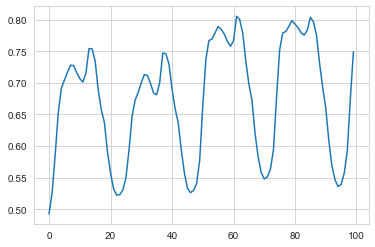

In [5]:
# sns.lineplot(data=Y1_e[9900:10000])
sns.lineplot(data=Y1_e[100:200])

<AxesSubplot:>

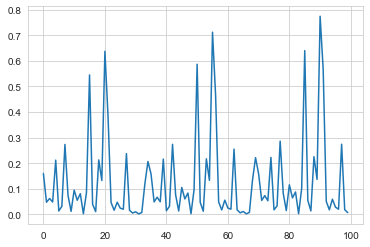

In [57]:
sns.lineplot(data=Y2_e[131:231])

<AxesSubplot:>

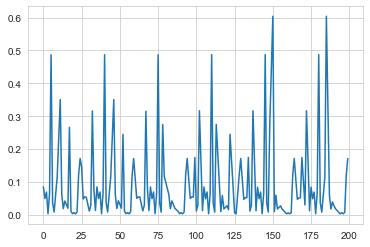

In [61]:
p = np.array(pm_elec[0][:]) # 100 steps ahead
p[p == 'N'] = np.nan
sns.lineplot(data=p.astype(float))